# Analyse d'une image de microscopie à l'aide du module scikit image
Ce notebook à pour objectif d'ilustrer une utilisation simplifé du module scikit image pour l'analyse d'une image issue d'un microscope photonique à épifluorescence. On cherche à compter le nombre de noyaux, ainsi que leurs taille et leurs intensité de fluorescence.

## Chargement des modules

In [1]:
# Module standard.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Module pour la manipulation d'image (scikit-image).

# sous-module contenant les fonctions de lecture et d'écriture d'une
# image.
import skimage.io
# Sous-module contenant les fonctions ...
import skimage.exposure
# Sous-module contenant les fonctions permettant de réaliser
# des mesures sur les images.
import skimage.measure
# Sous-module contenant les fonctions permmettant de réaliser
# un flitrage des image.
import skimage.filters

# module d'intéraction avec le système
import sys
import os

# Fonction pour le téléchargement de l'image à analiser
from urllib.request import urlretrieve

## Téléchargement et décompréssion de l'image à analyser

In [2]:
# Téléchargement de l'image si elle n'est pas présente dans le répertoire
# courrant.
if not os.path.isfile('FluorescentCells.zip'):
    print('Downloading the TIFF file for fluorescent cells image...')
    try:
        urlretrieve('https://imagej.nih.gov/ij/images/FluorescentCells.zip',
            'FluorescentCells.zip')
        print("ok")
    except:
        print("Unable to download the file!")
    print('Done!')

# Décompression du fichier FluorescentCells.zip si l'image n'est pas
# décompréssée.
if not os.path.isfile("FluorescentCells.tif"):
    !unzip FluorescentCells.zip

## Chargement et visualisation de l'image à analyser

Chargement de l'image dans un array numpy, provennant d'[NIH](https://imagej.nih.gov/ij/images/FluorescentCells.zip).

In [3]:
img = skimage.io.imread("FluorescentCells.tif")

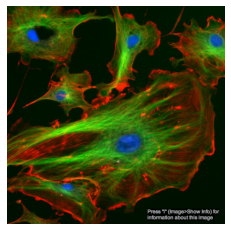

In [4]:
plt.imshow(img)
plt.axis("off");

L'image ci-dessus, que l'on va analyser (dont une description est disponible [ici](https://imagej.nih.gov/ij/images/FluorescentCells.txt)), correspond à une image de cellules endothéliales d'artère pulmonaire bovine. En bleu, il s'agit d'un marquage des noyaux à l'aide du DAPI. En vert, il s'agit d'un marquage de la tubuline. Puis en rouge, il s'agit d'un marquage des microtubules.

In [5]:
print(f"Dimensions du tableau numpy de l'image : {img.shape}")
print(f"Représentation du pixel (0, 0): {img[0, 0, :]}")

Dimensions du tableau numpy de l'image : (512, 512, 3)
Représentation du pixel (0, 0): [16 50  0]


Nous observons que notre image est tridimensionnelles dont la première dimension contient 512 colonnes, la seconde contient 512 ligne et la dernière correspondant aux différents canaux (RGB Dans notre exemple, le pixel (0, 0) à la valeur 16 pour le canal rouge, 50 pour le canal vert et 0 pour le canal bleu.

## Sélection du canal d'intérêt
Le canal d'intérêt est le bleu, puisque qu'il représente les noyaux marqué au DAPI.

In [6]:
canal_blue = img[:, :, 2]

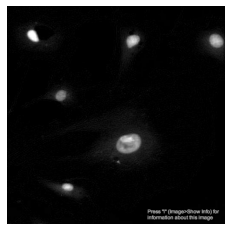

In [7]:
plt.imshow(canal_blue, cmap="gray")
plt.axis("off");

La sélection effectuée permet d'identifier clairement les noyaux.

## Estimation du seuil de sélection des noyaux

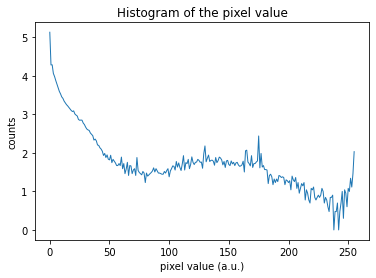

In [8]:
hist, bins = skimage.exposure.histogram(canal_blue)
plt.plot(bins, np.log10(hist), linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')
plt.title("Histogram of the pixel value");

On remarque un minimum local en 80 pour la valeur des pixels. Nous allons donc prendre une valeur de seuil de 80 pour la sélection des noyaux.

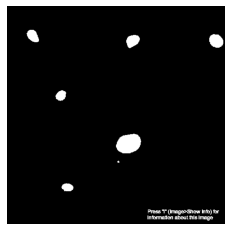

In [9]:
seuil = 80
img_noyau = canal_blue > seuil
plt.imshow(img_noyau, cmap="gray")
plt.axis("off");

On remarque qu'en utilisant un seuil de 80, on a une sélection spécifique des noyaux. Hormis la zone de texte en bas à droite de l'image et d'une petite zone non spécifique d'un noyau.

### Ajout d'un filtre gaussien

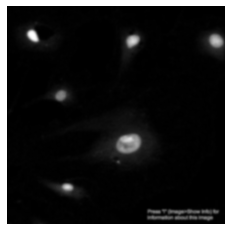

In [10]:
nuclei_filtered = skimage.filters.gaussian(canal_blue, sigma=2)
plt.imshow(nuclei_filtered, cmap="gray")
plt.axis("off");

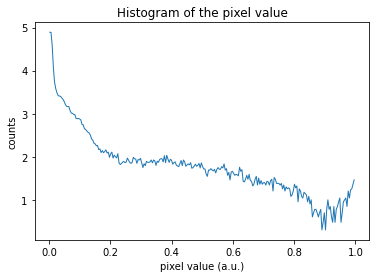

In [11]:
hist, bins = skimage.exposure.histogram(nuclei_filtered)
plt.plot(bins, np.log10(hist+1), linewidth=1)
plt.xlabel('pixel value (a.u.)')
plt.ylabel('counts')
plt.title("Histogram of the pixel value");

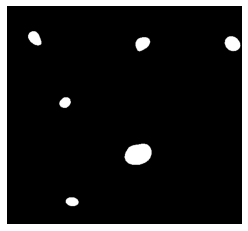

In [12]:
seuil = 0.3
img_noyau = nuclei_filtered > seuil
plt.imshow(img_noyau[:475, :], cmap="gray")
plt.axis("off");

On remarque qu'avec l'application d'un filtre gaussien et l'utilisation d'un seuil de 0.3, on obtient une sélection plus spécifique des nouyaux.

## Comptage du nombre de noyaux

In [13]:
labels = skimage.measure.label(img_noyau[:475,:])
print(labels.max())

6


On obtient un comptage de 6 noyaux pour cette image, une fois le texte enlever.